In [ ]:
# -*- coding: utf-8 -*-
"""GAN_MNIST.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KMVZC_qMZl2wBl573u-q6StWRWfC9z6C
"""

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
print(train_data)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear( hidden_dim*4, output_size)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        # final layer
        out = self.fc4(x)

        return out

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        out = F.tanh(self.fc4(x))

        return out

# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])



16
256
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           12560       input_encoder[0][0]              
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           12560       input_encoder[0][0]              
__________________________________________________________________________________________________
z (Lambda)                      (None, 16)           0           z_mean[0][0]                     
                                                                 z_log_var[0][0]     

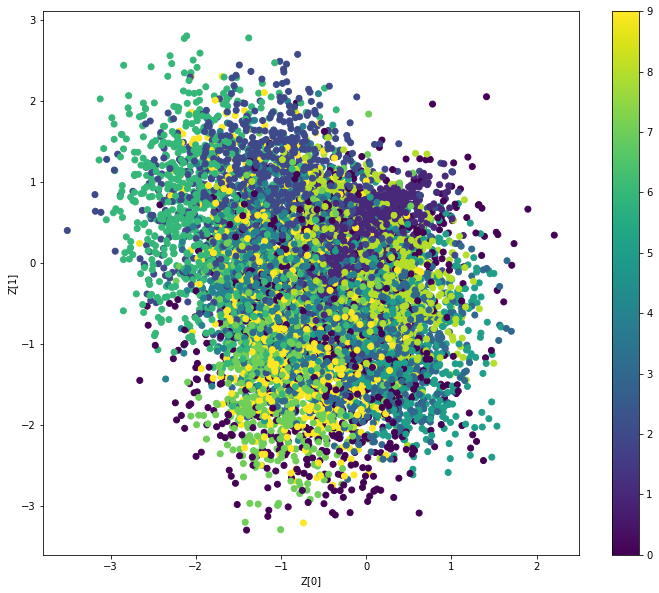

[[6.81020180e-03 7.55873322e-03 6.41018059e-03 ... 4.71398886e-03
  7.46823894e-03 5.65393036e-03]
 [8.08797267e-06 8.34050115e-06 7.87157114e-06 ... 7.79057154e-06
  8.23131359e-06 7.73100692e-06]
 [9.61012304e-01 9.67759252e-01 9.56666887e-01 ... 9.16270852e-01
  9.67391074e-01 9.44448411e-01]
 ...
 [1.15989745e-02 1.30913267e-02 1.08065298e-02 ... 7.35804159e-03
  1.29396552e-02 9.29226540e-03]
 [2.66322382e-02 3.01659591e-02 2.47639921e-02 ... 1.64398309e-02
  2.98129693e-02 2.11602356e-02]
 [3.77137476e-04 4.08425083e-04 3.61620710e-04 ... 2.96031620e-04
  4.03913757e-04 3.32178693e-04]]
[[1.02933249e-04 1.10430112e-04 9.85414590e-05 ... 8.39066197e-05
  1.09086272e-04 9.16236459e-05]
 [2.89863931e-11 2.73029030e-11 3.01956307e-11 ... 4.54750161e-11
  2.70327250e-11 3.40694799e-11]
 [1.09395344e-07 1.09974430e-07 1.09157320e-07 ... 1.23601353e-07
  1.08743983e-07 1.11644937e-07]
 ...
 [5.26265285e-06 5.49972265e-06 5.16225782e-06 ... 4.94650430e-06
  5.44506065e-06 4.99492717e-06]

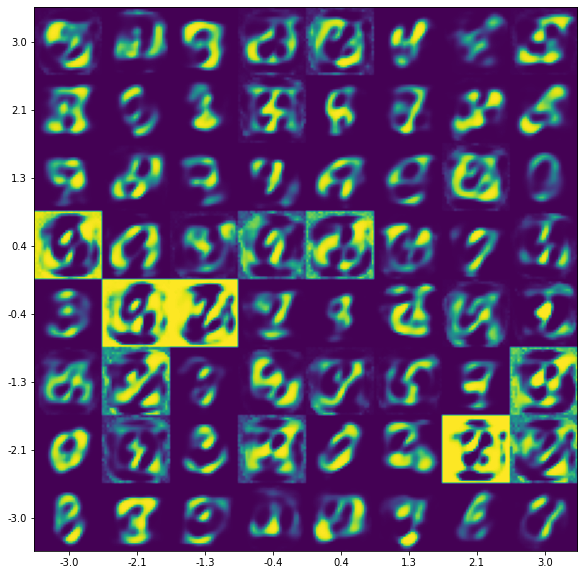

In [2]:
# -*- coding: utf-8 -*-
"""VAE-2.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Fi4TKMbnjg5_Pn4IoppJfAnuVQ5APm10
"""

#!/usr/bin/env python

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()
image_size = x_train_data.shape[1]
original_dim = image_size * image_size
x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])
x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255
input_shape = (original_dim, )
batch_size = 128

def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

def create_model(hidden_node, latent_node):
    # build encoder model
    # input layer
    encoder_inputs = Input(shape=input_shape, name='input_encoder')
    print(latent_node)
    print(hidden_node)
    # hidden layer
    # encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)

    z_mean = Dense(latent_node, name='z_mean')(encoder_inputs)
    z_log_var = Dense(latent_node, name='z_log_var')(encoder_inputs)

    # normalize log variance to std dev
    z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_encoder_inputs = Input(shape=(latent_node,), name='latent_sampling')
    # decoder_hidden = Dense(hidden_node, activation='relu')(latent_encoder_inputs)
    decoder_outputs = Dense(original_dim, activation='sigmoid')(latent_encoder_inputs)

    # instantiate decoder model
    decoder = Model(latent_encoder_inputs, decoder_outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    model_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, model_outputs, name='vae_mlp')
    
    reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    #vae.summary()
    return vae, encoder, decoder

def train_model(model):
    trained_model = model.fit(x_train_data, epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_data, None))
    return trained_model 

def plot_latent_space(encoder):
    z_test, _, _ = encoder.predict(x_test_data, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test_data)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()

def plot_vae_output(decoder,latent_dim):
    n = 8
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]    
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)
            print(input_decoded)
            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit
    
    plt.figure(figsize=(10, 10))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure)
    plt.savefig("VAE_Output")
    plt.show()

#Create VAE model with 2 code units and generating images by varying each code unit from -3 to 3
intermediate_dim = 256
latent_dim = 16
epochs = 50
vae, encoder, decoder = create_model(intermediate_dim, latent_dim)
trained_model = train_model(vae)
plot_latent_space(encoder)
plot_vae_output(decoder, latent_dim)